In [12]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import torch
import tomosipo as ts


In [16]:
from context import mvtomo
from mvtomo.algorithms_mv import OSEM, MLEM, CGNE
from mvtomo.utils import volshow, plot_imgs

In [30]:
# Phantom from the tomosipo example
N = 128
n_angles_scout = 10
n_angles_interior = 90

angles_scout = np.linspace(0,np.pi,n_angles_scout)
angles_interior = np.linspace(0,np.pi,n_angles_interior)

vol_shape =(N,N,N)

sino_shape1 =(N,int(1.5*N)) 
sino_shape2 =(N,int(0.5*N)) 

vg = ts.volume(shape=vol_shape)
full_pg = ts.parallel(angles=angles_scout, shape=sino_shape1)
roi_pg = ts.parallel(angles=angles_interior, shape=sino_shape2)

A = ts.operator(vg, full_pg)
A_roi = ts.operator(vg, roi_pg)

phantom = ts.phantom.hollow_box(ts.data(vg)).data/100
sino = A(phantom)
sino_roi = A_roi(phantom)



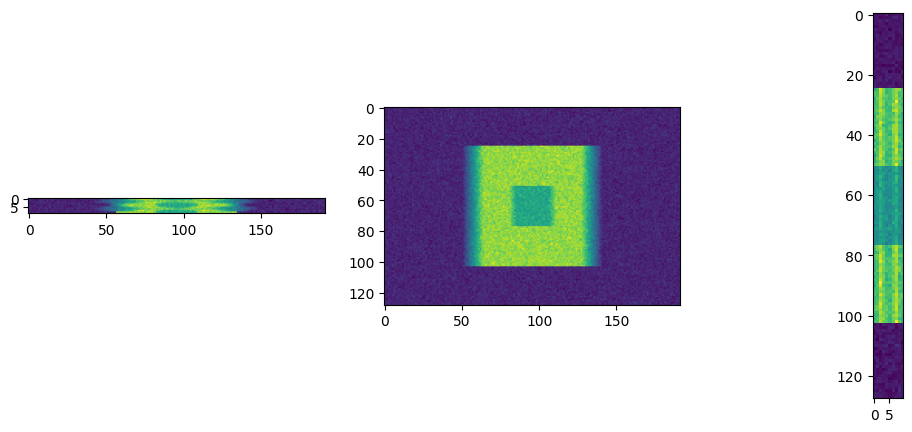

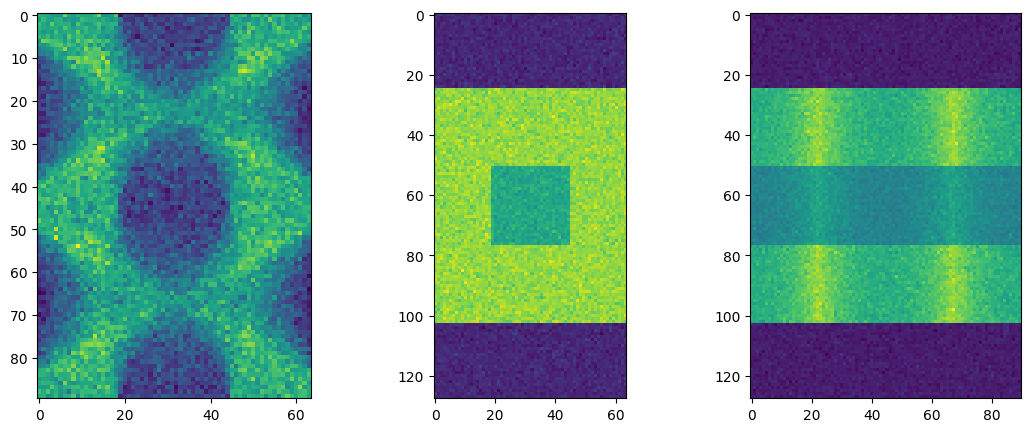

In [31]:
sino_noisy = mvtomo.add_poisson(sino, 1000)
sino_roi_noisy = mvtomo.add_poisson(sino_roi, 1000)

mvtomo.volshow(sino_noisy)
mvtomo.volshow(sino_roi_noisy)


C:\Users\axela\AppData\Local\miniconda3\lib\site-packages\tomosipo\links\numpy.py:27: UserWarning: The parameter initial_value is of type float64; expected `np.float32`. The type has been Automatically converted. Use `ts.link(x.astype(np.float32))' to inhibit this warning. 
  warnings.warn(


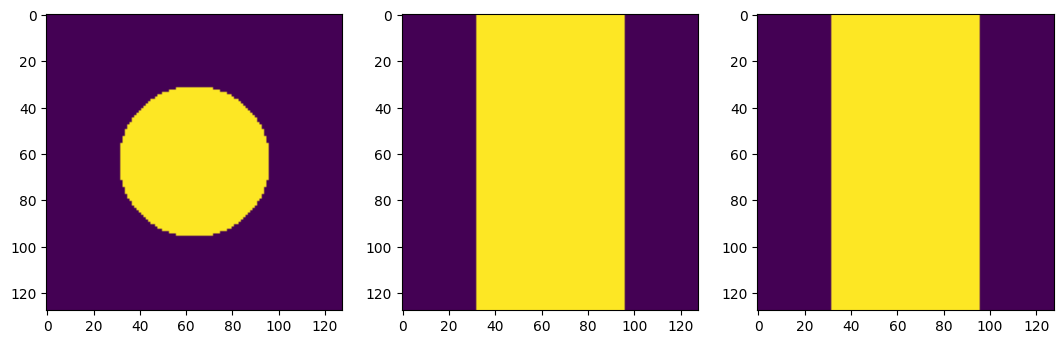

In [32]:
from skimage.metrics import peak_signal_noise_ratio
# mask for 'good' interior support
mask = A_roi.T(np.ones(sino_roi.shape))>(0.9*n_angles_interior)
mvtomo.volshow(mask)

def metric_roi(x, oracle):
    data_range = np.percentile(oracle,99)
    return peak_signal_noise_ratio(x[mask>0], oracle[mask>0], data_range=data_range)
    

In [33]:
n_iters = 50 
rec_mlem = MLEM(np.ones(phantom.shape), **kwargs)
rec_osem = OSEM(np.ones(phantom.shape), **kwargs)
rec_cgne = CGNE(np.zeros(phantom.shape), **kwargs)
rec_cgne_nn = CGNE(np.zeros(phantom.shape), nn_step=3,**kwargs)

rec_mlem.set_metric(metric_roi)
rec_osem.set_metric(metric_roi)
rec_cgne.set_metric(metric_roi)
rec_cgne_nn.set_metric(metric_roi)

vol_mlem, psnr_mlem = rec_mlem(n_iters,oracle = phantom)
vol_osem, psnr_osem = rec_osem(n_iters,oracle = phantom)
vol_cgne, psnr_cgne = rec_cgne(n_iters,oracle = phantom)
vol_cgne2, psnr_cgne2 = rec_cgne_nn(n_iters,oracle = phantom)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\axela\AppData\Local\miniconda3\lib\site-packages\tomosipo\links\torch.py:55: UserWarning: The parameter initial_value is of type torch.float64; expected `torch.float32`. The type has been automatically converted. Use `ts.link(x.to(dtype=torch.float32))' to inhibit this warning. 
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

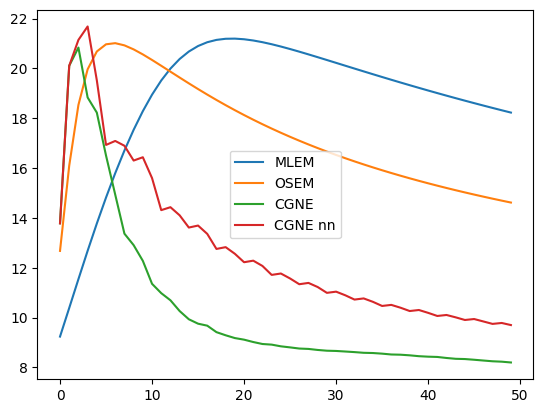

In [34]:
plt.figure()
plt.plot(psnr_mlem, label = 'MLEM')
plt.plot(psnr_osem, label = 'OSEM')
plt.plot(psnr_cgne, label = 'CGNE')
plt.plot(psnr_cgne2, label = 'CGNE nn')

plt.legend()


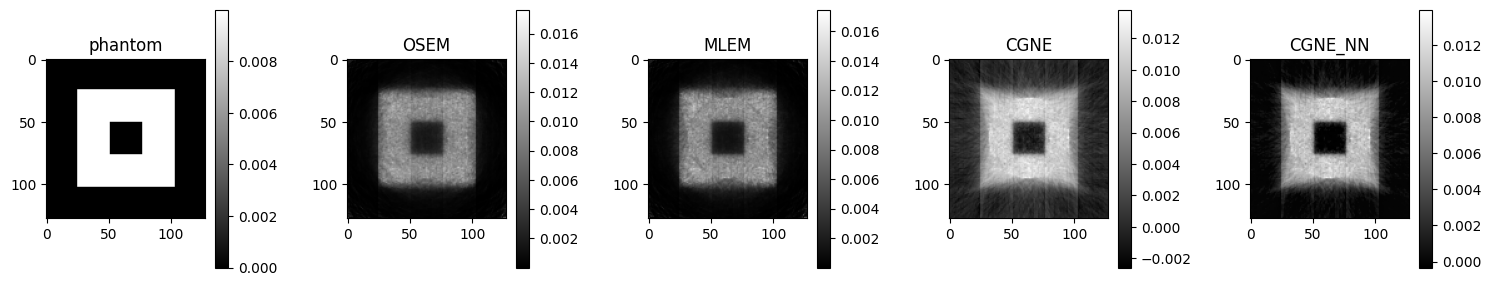

In [35]:
from mvtomo.utils import plot_imgs
plot_imgs(
    phantom=phantom[N//2],   
    OSEM=vol_osem[N//2],
    MLEM=vol_mlem[N//2],
    CGNE=vol_cgne[N//2],
    CGNE_NN=vol_cgne2[N//2],    
)
